In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict

In [97]:
# ================================
# LOAD DATA
# ================================
awards = pd.read_csv("../../initial_data/awards_players.csv")
coaches = pd.read_csv("../../initial_data/coaches.csv")
players_teams = pd.read_csv("../../initial_data/players_teams.csv")
players = pd.read_csv("../../initial_data/players.csv")
series_post = pd.read_csv("../../initial_data/series_post.csv")
teams_post = pd.read_csv("../../initial_data/teams_post.csv")
teams = pd.read_csv("../../initial_data/teams.csv")

## Player Based Development Curve

In [98]:
# ================================
# PLAYER GAME SCORE
# ================================
def get_player_game_score(players_teams_df, player_id, year):
    """
    Compute a player's game score for a given year.
    Returns a clean Python dictionary.
    """
    df_player = players_teams_df[
        (players_teams_df["playerID"] == player_id) &
        (players_teams_df["year"] == year)
    ].copy()

    if df_player.empty:
        return {
            "playerID": player_id,
            "year": year,
            "tmID": None,
            "Game_Score_Total": None,
            "Game_Score_Per_Game": None,
            "Game_Score_Per_Minute": None
        }

    # Base game score formula
    base_score = (
        df_player["points"]
        + 0.4 * df_player["fgMade"]
        - 0.7 * df_player["fgAttempted"]
        - 0.4 * (df_player["ftAttempted"] - df_player["ftMade"])
        + 0.7 * df_player["oRebounds"]
        + 0.3 * df_player["dRebounds"]
        + df_player["steals"]
        + 0.7 * df_player["assists"]
        + 0.7 * df_player["blocks"]
        - 0.4 * df_player["PF"]
        - df_player["turnovers"]
    )

    df_player["Game_Score_Total"] = base_score
    df_player["Game_Score_Per_Game"] = base_score / df_player["GP"].replace(0, np.nan)
    df_player["Game_Score_Per_Minute"] = base_score / df_player["minutes"].replace(0, np.nan)

    return {
        "playerID": player_id,
        "year": int(year),
        "tmID": ",".join(df_player["tmID"].unique()),
        "Game_Score_Total": float(df_player["Game_Score_Total"].sum(skipna=True)),
        "Game_Score_Per_Game": float(df_player["Game_Score_Per_Game"].mean(skipna=True)),
        "Game_Score_Per_Minute": float(df_player["Game_Score_Per_Minute"].mean(skipna=True)),
    }

example = get_player_game_score(players_teams, "aycocan01w", 1)
print("Example Player Game Score:\n", example)

Example Player Game Score:
 {'playerID': 'aycocan01w', 'year': 1, 'tmID': 'MIN,SEA', 'Game_Score_Total': 1.4000000000000001, 'Game_Score_Per_Game': -0.3999999999999999, 'Game_Score_Per_Minute': 0.13928571428571426}


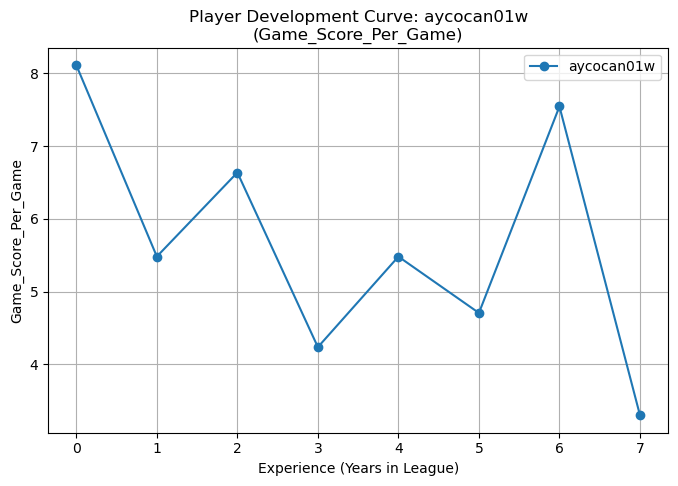

In [99]:
# ============================================================
# 1. PLAYER CAREER DEVELOPMENT CURVE
# ============================================================

def get_player_career_curve(players_teams_df, player_id):
    """
    Computes game score for every season of a player's career
    and returns a DataFrame with experience-year indexing.
    """
    df = players_teams_df[players_teams_df["playerID"] == player_id]
    
    if df.empty:
        return pd.DataFrame()

    seasons = sorted(df["year"].unique())
    first_year = seasons[0]

    rows = []
    for yr in seasons:
        score_data = get_player_game_score(players_teams_df, player_id, yr)
        rows.append(score_data)

    career_df = pd.DataFrame(rows)

    # Add experience (0 = rookie season)
    career_df["Experience"] = career_df["year"] - first_year

    # Keep sorted
    career_df = career_df.sort_values("Experience")

    return career_df


def plot_player_career_curve(career_df, player_id, metric="Game_Score_Per_Game"):
    """
    Plot a player's development curve.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(
        career_df["Experience"],
        career_df[metric],
        marker="o",
        label=f"{player_id}"
    )

    plt.title(f"Player Development Curve: {player_id}\n({metric})")
    plt.xlabel("Experience (Years in League)")
    plt.ylabel(metric)
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage
career = get_player_career_curve(players_teams, "abrossv01w")
plot_player_career_curve(career, "aycocan01w")

## League Wide Development Curve

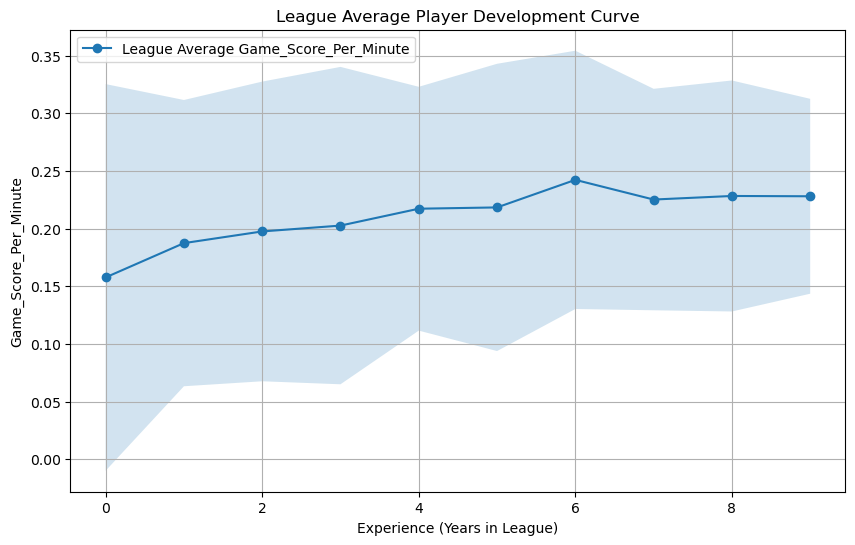

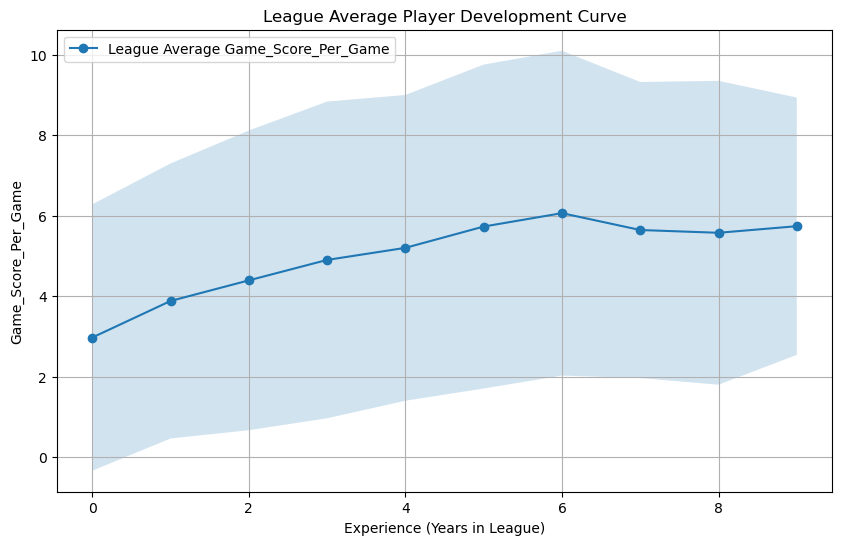

In [100]:
def compute_league_average_development_filtered(players_teams_df, 
                                                metric="Game_Score_Per_Game", 
                                                min_years=6, 
                                                min_total_minutes=500):
    """
    Computes the league average development curve considering only
    players with at least min_years of experience and min_total_minutes.
    """
    players = players_teams_df["playerID"].unique()
    experience_buckets = defaultdict(list)

    for pid in players:
        df_player = players_teams_df[players_teams_df["playerID"] == pid]
        
        # Skip players who haven't reached minimum years
        if df_player["year"].nunique() < min_years:
            continue
        
        # Skip players who haven't played enough minutes overall
        if df_player["minutes"].sum() < min_total_minutes:
            continue
        
        career = get_player_career_curve(players_teams_df, pid)
        if career.empty:
            continue
        
        for _, row in career.iterrows():
            exp = int(row["Experience"])
            val = row[metric]
            if not np.isnan(val):
                experience_buckets[exp].append(val)

    # Build the averaged curve
    avg_curve = []
    for exp in sorted(experience_buckets.keys()):
        vals = experience_buckets[exp]
        avg_curve.append({
            "Experience": exp,
            "Mean": np.mean(vals),
            "Std": np.std(vals),
            "Count": len(vals)
        })

    avg_df = pd.DataFrame(avg_curve)
    return avg_df


def plot_league_average_development(avg_df, metric_name="Game_Score_Per_Game"):
    """
    Plot the league-wide average curve with shaded variance.
    """
    plt.figure(figsize=(10, 6))

    plt.plot(
        avg_df["Experience"],
        avg_df["Mean"],
        marker="o",
        label=f"League Average {metric_name}"
    )

    # Add standard deviation shading
    plt.fill_between(
        avg_df["Experience"],
        avg_df["Mean"] - avg_df["Std"],
        avg_df["Mean"] + avg_df["Std"],
        alpha=0.2
    )

    plt.title("League Average Player Development Curve")
    plt.xlabel("Experience (Years in League)")
    plt.ylabel(metric_name)
    plt.grid(True)
    plt.legend()
    plt.show()

avg_curve_min = compute_league_average_development(players_teams, metric="Game_Score_Per_Minute")
avg_curve_game = compute_league_average_development(players_teams, metric="Game_Score_Per_Game")
plot_league_average_development(avg_curve_min, metric_name="Game_Score_Per_Minute")
plot_league_average_development(avg_curve_game, metric_name="Game_Score_Per_Game")

## Feature Engineering

In [101]:
def get_player_season_stats(players_teams_df, player_id, year): 
    """
    Returns stats for a given player and season.
    """
    df = players_teams_df[
        (players_teams_df["playerID"] == player_id) &
        (players_teams_df["year"] == year)
    ]

    if df.empty:
        return None

    score = get_player_game_score(players_teams_df, player_id, year)

    return {
        "playerID": player_id,
        "year": year,
        "tmID": df["tmID"].iloc[0],
        "GP": df["GP"].sum(),
        "minutes": df["minutes"].sum(),
        "PTS": df["points"].sum(),
        "REB": (df["oRebounds"] + df["dRebounds"]).sum(),
        "AST": df["assists"].sum(),
        "STL": df["steals"].sum(),
        "BLK": df["blocks"].sum(),
        "TOV": df["turnovers"].sum(),
        "Game_Score_Per_Game": score["Game_Score_Per_Game"],
        "Game_Score_Per_Minute": score["Game_Score_Per_Minute"],
        "Game_Score_Total": score["Game_Score_Total"]
    }


def get_player_experience(players_teams_df, player_id, year):
    seasons = sorted(players_teams_df[players_teams_df["playerID"] == player_id]["year"].unique())
    if not seasons:
        return 0
    first_year = seasons[0]
    return year - first_year


def get_previous_season_features(players_teams_df, player_id, year):
    return get_player_season_stats(players_teams_df, player_id, year - 1)


def compute_development(current_stats, previous_stats):
    if previous_stats is None:
        return None  # rookies have no development
    
    return {
        "Delta_Game_Score": current_stats["Game_Score_Per_Game"] - previous_stats["Game_Score_Per_Game"],
        "Delta_Minutes": current_stats["minutes"] - previous_stats["minutes"],
        "Delta_PTS": current_stats["PTS"] - previous_stats["PTS"],
        "Delta_REB": current_stats["REB"] - previous_stats["REB"],
        "Delta_AST": current_stats["AST"] - previous_stats["AST"],
    }


def expected_league_game_score(avg_curve, experience):
    row = avg_curve[avg_curve["Experience"] == experience]
    if row.empty:
        return None
    return float(row["Mean"].iloc[0])


def compute_expected_development(avg_curve, experience):
    exp_current = expected_league_game_score(avg_curve, experience)
    exp_prev = expected_league_game_score(avg_curve, experience - 1)

    if exp_prev is None or exp_current is None:
        return None

    return exp_current - exp_prev


def compute_trend(df, player, year, stat="PTS"):
    values = []
    for offset in [1, 2, 3]:
        row = get_player_season_stats(df, player, year - offset)
        if row is None:
            return None
        values.append(row.get(stat))
    if None in values:
        return None
    
    return (values[0] - values[1]) + (values[1] - values[2])


def compute_returning_minutes_share(players_teams_df, pid, year):
    team = players_teams_df[(players_teams_df["playerID"] == pid) &
                            (players_teams_df["year"] == year)]["tmID"].iloc[0]

    prev_year = year - 1

    # minutes played by team last season
    prev_team_players = players_teams_df[
        (players_teams_df["tmID"] == team) &
        (players_teams_df["year"] == prev_year)
    ]

    if len(prev_team_players) == 0:
        return 0.0

    total_prev_minutes = prev_team_players["minutes"].sum()

    # minutes returned by players still on roster current year
    current_team_players = players_teams_df[
        (players_teams_df["tmID"] == team) &
        (players_teams_df["year"] == year)
    ]

    returning_minutes = prev_team_players[
        prev_team_players["playerID"].isin(current_team_players["playerID"])
    ]["minutes"].sum()

    return returning_minutes / total_prev_minutes if total_prev_minutes > 0 else 0.0


def compute_minutes_freed(players_teams_df, tmID, year):
    curr_team = players_teams_df[(players_teams_df["tmID"] == tmID) & 
                                 (players_teams_df["year"] == year)]

    prev_team = players_teams_df[(players_teams_df["tmID"] == tmID) & 
                                 (players_teams_df["year"] == year - 1)]

    if prev_team.empty:
        return 0.0  # expansion or first year available

    # players who are NOT in current year
    left_players = prev_team[~prev_team["playerID"].isin(curr_team["playerID"])]

    return float(left_players["minutes"].sum())


# Build the full player–year dataset
def build_mip_training_table(players_teams_df, avg_curve):
    rows = []

    players = players_teams_df["playerID"].unique()
    years = sorted(players_teams_df["year"].unique())

    for pid in players:
        for yr in years:

            # --- CURRENT SEASON BASIC DATA ---
            current = get_player_seas   on_stats(players_teams_df, pid, yr)
            if current is None:
                continue

            # --- EXPERIENCE (before season) ---
            exp = get_player_experience(players_teams_df, pid, yr)

            # --- PREVIOUS SEASON STATS ---
            prev = get_previous_season_features(players_teams_df, pid, yr)
            if prev is None:
                continue  # cannot do preseason model for players with no previous season

            # --- AGE ---
            # age = current.get("Age", None)

            # --- TEAM CHANGE ---
            if prev is None:
                team_change = 0
            else:
                team_change = int(current["tmID"] != prev["tmID"])

            # --- 3-YEAR TRENDS ---
            pts_trend_3yr = compute_trend(players_teams_df, pid, yr, stat="PTS")
            minutes_trend_3yr = compute_trend(players_teams_df, pid, yr, stat="Minutes")

            # --- EXPECTED IMPROVEMENT (based on curve & experience) ---
            expected_dev = compute_expected_development(avg_curve, exp)

            # --- TEAM CONTINUITY (returning minutes share) ---
            returning_minutes_share = compute_returning_minutes_share(players_teams_df, pid, yr)

            # Projected Role Increase (more minutes available = bigger role)
            projected_role_increase = float(expected_dev) - 0.7 * float(returning_minutes_share)

            # Coach Change
            if prev:
                coach_change = int(current.get("coachID") != prev.get("coachID"))
            else:
                coach_change = 0

            minutes_freed = compute_minutes_freed(players_teams_df, current["tmID"], yr)

            # --- TARGET VARIABLE ---
            won_mip = int(
                (
                    (awards["playerID"] == pid) &
                    (awards["year"] == yr) &
                    (awards["award"] == "Most Improved Player")
                ).any()
            )

            # --- BUILD ROW ---
            rows.append({
                "playerID": pid,
                "year": yr,
                # "Age": age,
                "Experience": exp,

                # previous-season data only
                "GS_Prev": prev["Game_Score_Per_Game"],
                "PTS_Prev": prev["PTS"],
                "MIN_Prev": prev["minutes"],

                # new preseason features
                "Team_Change": team_change,
                "PTS_Trend_3yr": pts_trend_3yr,
                "Minutes_Trend_3yr": minutes_trend_3yr,
                "Returning_Minutes_Share": returning_minutes_share,
                "Expected_Improvement": expected_dev,
                "Projected_Role_Increase": projected_role_increase,
                "Coach_Change": coach_change,
                "Minutes_Freed": minutes_freed,

                # target
                "Won_MIP": won_mip
            })

    df = pd.DataFrame(rows)

    # Remove any players with insufficient data
    df = df.dropna(subset=["GS_Prev", "PTS_Prev", "MIN_Prev"])

    df.to_csv("training_data_mip.csv", index=False)
    return df




mip_training_data = build_mip_training_table(players_teams, avg_curve_game)
print("MIP Training Data Sample:\n", mip_training_data.head())

MIP Training Data Sample:
      playerID  year  Experience   GS_Prev  PTS_Prev  MIN_Prev  Team_Change  \
0  abrossv01w     3           1  8.111538       343       846            0   
1  abrossv01w     4           2  5.481481       314       805            0   
2  abrossv01w     5           3  6.636667       318       792            0   
3  abrossv01w     6           4  4.236364       146       462            0   
4  abrossv01w     7           5  5.480645       304       777            0   

   PTS_Trend_3yr Minutes_Trend_3yr  Returning_Minutes_Share  \
0            NaN              None                 0.800696   
1            NaN              None                 0.841343   
2          -25.0              None                 0.586315   
3         -168.0              None                 0.676431   
4          -14.0              None                 0.565332   

   Expected_Improvement  Projected_Role_Increase  Coach_Change  Minutes_Freed  \
0              0.908196                 0.34

## Predicative Model

In [138]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# =============================
# 1. Load preseason dataset
# =============================
df = pd.read_csv("training_data_mip.csv")

# =============================
# 2. Preseason feature set
# =============================
feature_cols = [
    "GS_Prev",
    "PTS_Prev",
    "MIN_Prev",
    # "Experience",
    # "Age",
    # "Team_Change",
    # "PTS_Trend_3yr",
    # "Minutes_Trend_3yr",
    "Returning_Minutes_Share",
    # "Expected_Improvement",
    "Projected_Role_Increase",
    # "Coach_Change",
    "Minutes_Freed"
]

# =============================
# 3. Identify seasons with ≥1 winner
# =============================
season_winners = df.groupby("year")["Won_MIP"].sum()
valid_seasons = season_winners[season_winners > 0].index.tolist()

print("Valid seasons for evaluation:", valid_seasons)

# =============================
# 4. Evaluation config
# =============================
topk_values = [1, 3, 5, 20]
hit_counts = {k: 0 for k in topk_values}
all_top5_results = []

# =============================
# 5. Leave-One-Season-Out
# =============================
for year in valid_seasons:

    print(f"\nEvaluating Season {year}...")

    train = df[df["year"] != year]
    test  = df[df["year"] == year].copy()

    X_train = train[feature_cols].fillna(0)
    y_train = train["Won_MIP"]

    X_test  = test[feature_cols].fillna(0)

    # Train the Random Forest
    model = RandomForestClassifier(
        n_estimators=600,
        max_depth=6,                 # control overfitting
        min_samples_split=20,
        min_samples_leaf=10,
        max_features=0.5,            # randomness improves generalization
        class_weight={0:1, 1:200},   # rare event boosting
        n_jobs=-1,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Predict probabilities
    test["Pred_Prob"] = model.predict_proba(X_test)[:, 1]

    # Rank players within the season
    test["Rank"] = test["Pred_Prob"].rank(
        ascending=False,
        method="first"
    )

    # Evaluate top-k hit rates
    for k in topk_values:
        topk = test[test["Rank"] <= k]
        if (topk["Won_MIP"] == 1).any():
            hit_counts[k] += 1

    # Store top-5 for inspection
    all_top5_results.append(test[test["Rank"] <= 5])

# =============================
# 6. Compute hit rates
# =============================
total = len(valid_seasons)
print("\n======= LOSO Results =======")

for k in topk_values:
    print(f"Top-{k} Hit Rate: {hit_counts[k]}/{total} = {100*hit_counts[k]/total:.2f}%")

# =============================
# 7. Save all top-5 candidates
# =============================
top5_df = pd.concat(all_top5_results).sort_values(["year", "Rank"])
top5_df.to_csv("preseason_mip_top5_predictions.csv", index=False)

print("\nTop-5 predictions saved to preseason_mip_top5_predictions.csv")


Valid seasons for evaluation: [2, 3, 4, 5, 8, 9, 10]

Evaluating Season 2...

Evaluating Season 3...

Evaluating Season 4...

Evaluating Season 5...

Evaluating Season 8...

Evaluating Season 9...

Evaluating Season 10...

======= LOSO Results =======
Top-1 Hit Rate: 0/7 = 0.00%
Top-3 Hit Rate: 1/7 = 14.29%
Top-5 Hit Rate: 1/7 = 14.29%
Top-20 Hit Rate: 3/7 = 42.86%

Top-5 predictions saved to preseason_mip_top5_predictions.csv


## Feature Importance

                   Feature  Importance
1                 PTS_Prev    0.220782
0                  GS_Prev    0.204295
2                 MIN_Prev    0.178662
5            Minutes_Freed    0.142596
4  Projected_Role_Increase    0.138336
3  Returning_Minutes_Share    0.115329


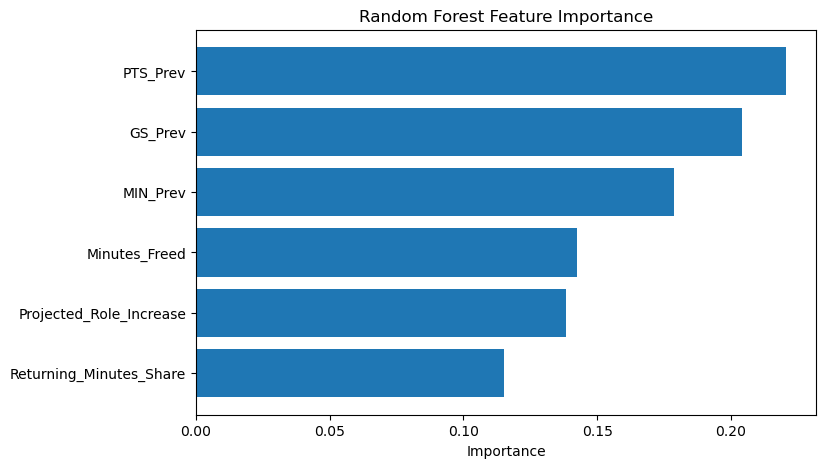

In [139]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest on all data (or leave-one-season-out for robustness)
X = df[feature_cols].fillna(0)
y = df['Won_MIP']

model = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=42, n_jobs=-1)
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
feat_imp = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_imp)

# Optional: plot feature importance
plt.figure(figsize=(8,5))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()


## Overfitting

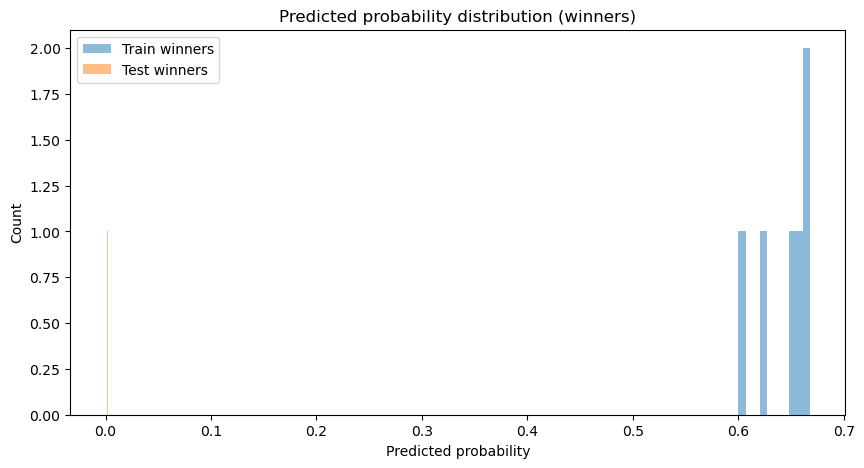

Top-5 Hit Rate - Train: 71.43%
Top-5 Hit Rate - Test: 0.00%


In [140]:
train = df[df['year'] < 9]
test = df[df['year'] >= 9]

X_train = train[feature_cols].fillna(0)
y_train = train['Won_MIP']
X_test = test[feature_cols].fillna(0)
y_test = test['Won_MIP']

model.fit(X_train, y_train)

# Predicted probabilities
train_probs = model.predict_proba(X_train)[:,1]
test_probs = model.predict_proba(X_test)[:,1]

# Compare distributions
plt.figure(figsize=(10,5))
plt.hist(train_probs[y_train==1], bins=10, alpha=0.5, label='Train winners')
plt.hist(test_probs[y_test==1], bins=10, alpha=0.5, label='Test winners')
plt.xlabel('Predicted probability')
plt.ylabel('Count')
plt.title('Predicted probability distribution (winners)')
plt.legend()
plt.show()

def top_k_hit_rate(df, model, k=5):
    df = df.copy()
    df['Pred_Prob'] = model.predict_proba(df[feature_cols].fillna(0))[:,1]
    df['Rank'] = df.groupby('year')['Pred_Prob'].rank(ascending=False, method='first')
    hits = 0
    for year in df['year'].unique():
        topk = df[(df['year'] == year) & (df['Rank'] <= k)]
        if (topk['Won_MIP'] == 1).any():
            hits += 1
    return hits / df['year'].nunique()

train_hit = top_k_hit_rate(train, model, k=5)
test_hit = top_k_hit_rate(test, model, k=5)

print(f"Top-5 Hit Rate - Train: {train_hit*100:.2f}%")
print(f"Top-5 Hit Rate - Test: {test_hit*100:.2f}%")